# MODEL GLM1
### Contains only fixed-before-conditional trials without intervening BLs
### Combines A & C trials into single regressor
### Accounts for last three noisy volumes in Lvl 1 analysis (FSL ROI -- ExtractROI)

# ROI mask specs:
### Hippocampus (FS labels: hippocampus [17, 53])
### Putamen (FS labels: putamen [12, 51])
### Medial PFC (FS labels: rostral anterior cingulate [1026, 2026] & caudal anterior cingulate [1002, 2002])
### Dorsal caudate (hand-drawn)

In [1]:
from os.path import join
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
sns.set_palette('muted')

subs = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']
proj_dir = '/home/data/madlab/Mattfeld_WMAZE' 
mask_filenames = []
cope_files = []
for sub in subs:
    mask_glob = glob(proj_dir + '/derivatives/roi_masks/hamm/anat_masks/_subject_id_' + sub + '/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_glob))
    copes_glob = glob(proj_dir + '/derivatives/Hamm_CellReports/GLM1/lvl2/' + sub + '/fixedfx/cope_*')
    cope_files.append(sorted(copes_glob))
    if len(cope_files[-1]) == 0:
        print(sub)

## Double-check the array indexing for masks and copes

In [2]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7]) 

0 lh-all_mPFC_warped
1 lh-dlPFC_warped
2 lh-dmPFC_warped
3 lh-hippocampus_warped
4 lh-mPFC_fs-3reg_warped
5 lh-mPFC_fs_warped
6 lh-mPFC_lausanne_warped
7 lh-motor_warped
8 lh-parsT_warped
9 lh_caudate_anat_mask_warped
10 lh_insula_warped
11 lh_vocc_warped
12 rh_caudate_anat_mask_warped
13 rh-all_mPFC_warped
14 rh-dlPFC_warped
15 rh-dmPFC_warped
16 rh-hippocampus_warped
17 rh-mPFC_fs-3reg_warped
18 rh-mPFC_fs_warped
19 rh-mPFC_lausanne_warped
20 rh-motor_warped
21 rh-parsT_warped
22 rh_insula_warped
23 rh_vocc_warped
24 lh-putamen_warped
25 lh_dlpfc_warped
26 lh_dlpfc_warped
27 rh-putamen_warped


In [3]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-1][5:-7]) 

0 all_before_B_corr
1 all_before_B_incorr
2 all_corr_minus_all_incorr
3 all_incorr_minus_all_corr
4 all_remaining


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
all_data = {'subjid':[],
            'lhhp_all_before_B_corr':[], 'rhhp_all_before_B_corr':[], 
            'lhhp_all_before_B_incorr':[], 'rhhp_all_before_B_incorr':[],            
            'lhmpfc_all_before_B_corr':[], 'rhmpfc_all_before_B_corr':[], 
            'lhmpfc_all_before_B_incorr':[], 'rhmpfc_all_before_B_incorr':[],            
            'lhcaud_all_before_B_corr':[], 'rhcaud_all_before_B_corr':[], 
            'lhcaud_all_before_B_incorr':[], 'rhcaud_all_before_B_incorr':[],            
            'lhput_all_before_B_corr':[], 'rhput_all_before_B_corr':[], 
            'lhput_all_before_B_incorr':[], 'rhput_all_before_B_incorr':[]}

for i in range(len(subs)):
    all_data['subjid'].append(subs[i])
    #ROI masks
    lh_hp_img = nb.load(mask_filenames[i][3])
    rh_hp_img = nb.load(mask_filenames[i][16])
    lh_mpfc_img = nb.load(mask_filenames[i][5])
    rh_mpfc_img = nb.load(mask_filenames[i][18])
    lh_caud_img = nb.load(mask_filenames[i][9])
    rh_caud_img = nb.load(mask_filenames[i][12])
    lh_put_img = nb.load(mask_filenames[i][24])
    rh_put_img = nb.load(mask_filenames[i][27])
    #copes
    all_before_B_corr_img = nb.load(cope_files[i][0])
    all_before_B_incorr_img = nb.load(cope_files[i][1])    
    
    region = ['hp', 'mpfc', 'caud', 'put']
    learn_type = ['all_before_B_corr', 'all_before_B_incorr']   
    for r in region:
        for l in learn_type:
            lh_data = eval('{0}_img.get_fdata()[lh_{1}_img.get_fdata() > 0.]'.format(l,r))
            all_data['lh{0}_{1}'.format(r,l)].append(np.mean(lh_data))            
            rh_data = eval('{0}_img.get_fdata()[rh_{1}_img.get_fdata() > 0.]'.format(l,r))
            all_data['rh{0}_{1}'.format(r,l)].append(np.mean(rh_data))
    
all_data_df = pd.DataFrame(all_data)

### Combine the two hemispheres to create one regional average

In [5]:
region = ['hp', 'mpfc', 'caud', 'put']
learn_type = ['all_before_B_corr', 'all_before_B_incorr']
for r in region:
    for l in learn_type:
        all_data_df['{0}_{1}'.format(r,l)] = (all_data_df['lh{0}_{1}'.format(r,l)] 
                                              + all_data_df['rh{0}_{1}'.format(r,l)])/2.

### Region-specific dataframes for producing plots

In [6]:
hp_plot = {}
mpfc_plot = {}
caud_plot = {}
put_plot = {}

for i in ['hp', 'mpfc', 'caud', 'put']:
    exec('{0}_plot["corr"] = all_data_df["{0}_all_before_B_corr"]'.format(i))
    exec('{0}_plot["incorr"] = all_data_df["{0}_all_before_B_incorr"]'.format(i))
    exec('{0}_plot_df = pd.DataFrame.from_dict({0}_plot)'.format(i))

# Hippocampus

Descriptives
Mean corr:  -1.5970450090489046
STD corr:  2.311401997721194

Mean incorr:  -2.6919804070271622
STD incorr:  2.447828106852829

Fixed Before Correct vs. Incorrect
t-test (-3.2747549320110543, 0.003985559295304508) <---- **
Cohen's d =  -0.6339868198348955


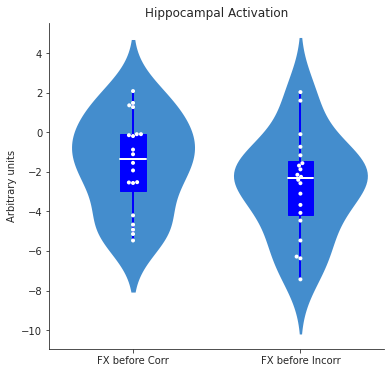

In [7]:
print('Descriptives')
for key in hp_plot:
    print('Mean {0}: '.format(key), np.mean(hp_plot['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(hp_plot['{0}'.format(key)]))
    print('')
N = 2
conditions = ['FX before Corr', 'FX before Incorr']
allsubjs = [hp_plot['corr'], hp_plot['incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#278fea', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,showcaps=False, 
           boxprops=dict(color='blue', facecolor='blue'),
           whiskerprops=dict(color='blue', linewidth=2, linestyle="-"),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
print('Fixed Before Correct vs. Incorrect')
#use Shapiro test to determine normality of distributions
if stats.shapiro(hp_plot['corr'])[1] < 0.049 or stats.shapiro(hp_plot['incorr'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(hp_plot['incorr'], hp_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(hp_plot['incorr'], hp_plot['corr'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(hp_plot['incorr'], hp_plot['corr'])[:])
else: #normal distributions
    if stats.ttest_rel(hp_plot['incorr'], hp_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(hp_plot['incorr'], hp_plot['corr'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(hp_plot['incorr'], hp_plot['corr'])[:])   
cohens_d = ((np.average(hp_plot['incorr'])-np.average(hp_plot['corr'])) 
            /(sqrt((np.std(hp_plot['incorr'],ddof=1))**2+np.std(hp_plot['corr'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/GLM1_hpc.png", dpi=1000)
plt.show() 

# Medial PFC

Descriptives
Mean corr:  -1.6738333633549858
STD corr:  3.539253742373969

Mean incorr:  -1.9298172448426214
STD incorr:  3.489736120917777

Fixed Before Correct vs. Incorrect
t-test (-0.8153472649035393, 0.42497699830914815)
Cohen's d =  -0.10039584112656293


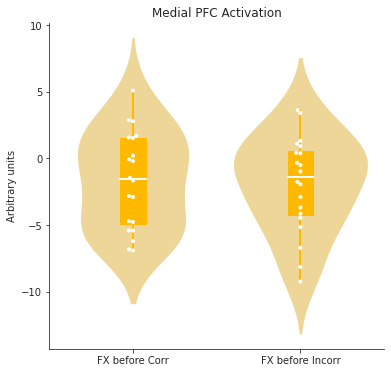

In [8]:
print('Descriptives')
for key in mpfc_plot:
    print('Mean {0}: '.format(key), np.mean(mpfc_plot['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(mpfc_plot['{0}'.format(key)]))
    print('')
N = 2
conditions = ['FX before Corr', 'FX before Incorr']
allsubjs = [mpfc_plot['corr'], mpfc_plot['incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#ffde85', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#ffb900', facecolor='#ffb900'),
           whiskerprops=dict(color='#ffb900', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial PFC Activation")
print('Fixed Before Correct vs. Incorrect')
#use Shapiro test to determine normality of distributions
if stats.shapiro(mpfc_plot['corr'])[1] < 0.049 or stats.shapiro(mpfc_plot['incorr'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(mpfc_plot['incorr'], mpfc_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(mpfc_plot['incorr'], mpfc_plot['corr'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(mpfc_plot['incorr'], mpfc_plot['corr'])[:])
else: #normal distributions
    if stats.ttest_rel(mpfc_plot['incorr'], mpfc_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(mpfc_plot['incorr'], mpfc_plot['corr'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(mpfc_plot['incorr'], mpfc_plot['corr'])[:])   
cohens_d = ((np.average(mpfc_plot['incorr'])-np.average(mpfc_plot['corr'])) 
            /(sqrt((np.std(mpfc_plot['incorr'],ddof=1))**2+np.std(mpfc_plot['corr'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/GLM1_mpfc.png", dpi=1000)
plt.show() 

# Caudate

Descriptives
Mean corr:  1.015675791669723
STD corr:  2.9366371037342334

Mean incorr:  1.5827591193518684
STD incorr:  2.9619166127518963

Fixed Before Correct vs. Incorrect
t-test (1.5093791385758, 0.14765267259222015)
Cohen's d =  0.26503556044221516


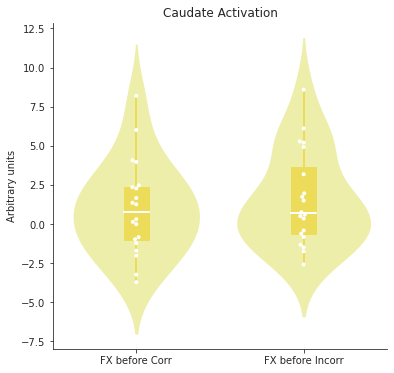

In [9]:
print('Descriptives')
for key in caud_plot:
    print('Mean {0}: '.format(key), np.mean(caud_plot['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(caud_plot['{0}'.format(key)]))
    print('')
N = 2
conditions = ['FX before Corr', 'FX before Incorr']
allsubjs = [caud_plot['corr'], caud_plot['incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#fcfc9d', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#eddc5a', facecolor='#eddc5a'),
           whiskerprops=dict(color='#eddc5a', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
print('Fixed Before Correct vs. Incorrect')
#use Shapiro test to determine normality of distributions
if stats.shapiro(caud_plot['corr'])[1] < 0.049 or stats.shapiro(caud_plot['incorr'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(caud_plot['incorr'], caud_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(caud_plot['incorr'], caud_plot['corr'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(caud_plot['incorr'], caud_plot['corr'])[:])
else: #normal distributions
    if stats.ttest_rel(caud_plot['incorr'], caud_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(caud_plot['incorr'], caud_plot['corr'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(caud_plot['incorr'], caud_plot['corr'])[:])   
cohens_d = ((np.average(caud_plot['incorr'])-np.average(caud_plot['corr'])) 
            /(sqrt((np.std(caud_plot['incorr'],ddof=1))**2+np.std(caud_plot['corr'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/GLM1_caud.png", dpi=1000)
plt.show() 

# Putamen

Descriptives
Mean corr:  0.8238828162045453
STD corr:  3.020729955541268

Mean incorr:  -0.4356327242494058
STD incorr:  3.1150388426699007

Fixed Before Correct vs. Incorrect
Wilcoxon (37.0, 0.009435653686523438) <---- **
Cohen's d =  -0.5658353101223998


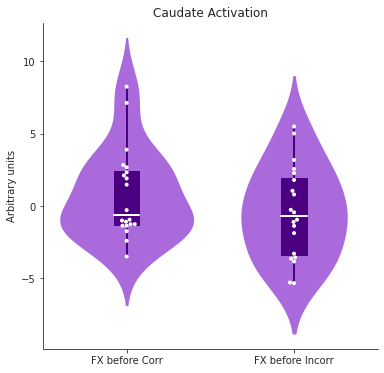

In [10]:
print('Descriptives')
for key in put_plot:
    print('Mean {0}: '.format(key), np.mean(put_plot['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(put_plot['{0}'.format(key)]))
    print('')
N = 2
conditions = ['FX before Corr', 'FX before Incorr']
allsubjs = [put_plot['corr'], put_plot['incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#af52f4', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='indigo', facecolor='indigo'),
           whiskerprops=dict(color='indigo', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
print('Fixed Before Correct vs. Incorrect')
#use Shapiro test to determine normality of distributions
if stats.shapiro(put_plot['corr'])[1] < 0.049 or stats.shapiro(put_plot['incorr'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(put_plot['incorr'], put_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(put_plot['incorr'], put_plot['corr'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(put_plot['incorr'], put_plot['corr'])[:])
else: #normal distributions
    if stats.ttest_rel(put_plot['incorr'], put_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(put_plot['incorr'], put_plot['corr'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(put_plot['incorr'], put_plot['corr'])[:])   
cohens_d = ((np.average(put_plot['incorr'])-np.average(put_plot['corr'])) 
            /(sqrt((np.std(put_plot['incorr'],ddof=1))**2+np.std(put_plot['corr'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/GLM1_put.png", dpi=1000)
plt.show() 

# Scatterplots

## - Compares avg preceding fixed activation with avg performance on conditional trials

In [11]:
all_prop_corr = []

for sub in subs:
    sub_dir = '/home/data/madlab/Mattfeld_WMAZE/behav/{0}/'.format(sub)
    dir_file = glob(join(sub_dir, '{0}_wmazebl_2015*.txt'.format(sub)))   
    dir_file.sort()    
    
    run1 = pd.read_table(dir_file[0]) #open each run and cut off last three trials
    run1 = run1[:-3]
    run2 = pd.read_table(dir_file[1])
    run2 = run2[:-3]
    run3 = pd.read_table(dir_file[2])
    run3 = run3[:-3]
    run4 = pd.read_table(dir_file[3])
    run4 = run4[:-3]
    run5 = pd.read_table(dir_file[4])
    run5 = run5[:-3]
    run6 = pd.read_table(dir_file[5])
    run6 = run6[:-3]
    
    all_runs = [run1, run2, run3, run4, run5, run6] #concatenate all 6 runs   
    data_set = pd.concat(all_runs)
    
    trialtype = data_set['TrialType'].values #Numpy arrays for trial type and accuracy
    correct = data_set['Correct'].values 
    
    trial_shift = trialtype[:-1] #removing last trial and shifting down 
    trial_shift = np.insert(trial_shift, 0, -1)
    correct_shift = correct[:-1]
    correct_shift = np.insert(correct_shift, 0, -1)
    #grab indices for trials matching specified criteria
    corr = sorted(np.where(((trialtype == 'B') & (correct == 1)) & (trial_shift != 'BL'))[0])    
    incorr = sorted(np.where(((trialtype == 'B') & (correct == 0)) & (trial_shift != 'BL'))[0])      
    all_prop_corr.append(len(corr)/float(len(corr)+len(incorr))) #append proportion of correct trials

all_data_df['prop_corr'] = all_prop_corr

### Average regional activation across all trial types

In [12]:
region = ['hp', 'mpfc', 'caud', 'put']
for r in region:
    all_data_df['{0}_all_before_B'.format(r,l)] = (all_data_df['lh{0}_all_before_B_corr'.format(r)] 
                                                   + all_data_df['rh{0}_all_before_B_corr'.format(r)]
                                                   + all_data_df['lh{0}_all_before_B_incorr'.format(r)] 
                                                   + all_data_df['rh{0}_all_before_B_incorr'.format(r)])/4.

## Hippocampus

FIXED --> COND (0.35565226749118173, 0.1238202317364216)


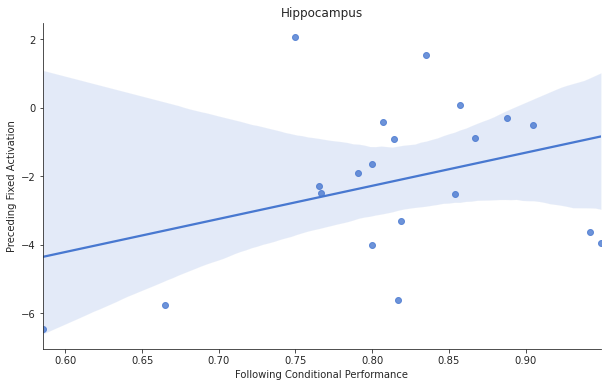

In [13]:
x = all_data_df['prop_corr']
y = all_data_df['hp_all_before_B']

print('FIXED --> COND', pearsonr(x,y))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'prop_corr', y = 'hp_all_before_B', data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Hippocampus')
plt.show()

## mPFC

FIXED --> COND (0.3067768900267693, 0.18830809874412033)


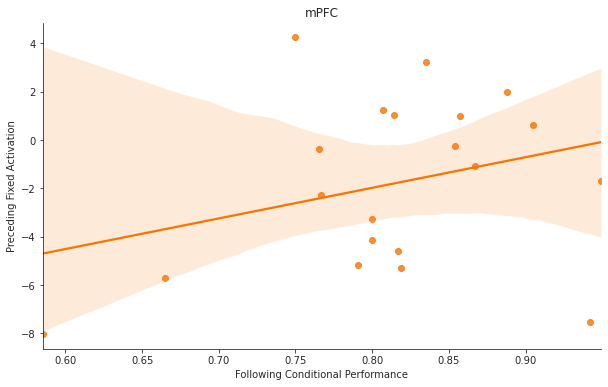

In [14]:
x = all_data_df['prop_corr']
y = all_data_df['mpfc_all_before_B']

print('FIXED --> COND', pearsonr(x,y))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'prop_corr', y = 'mpfc_all_before_B', color = '#f97401', data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('mPFC')
plt.show()

## Caudate

FIXED --> COND (0.14526916007901522, 0.5411415087898405)


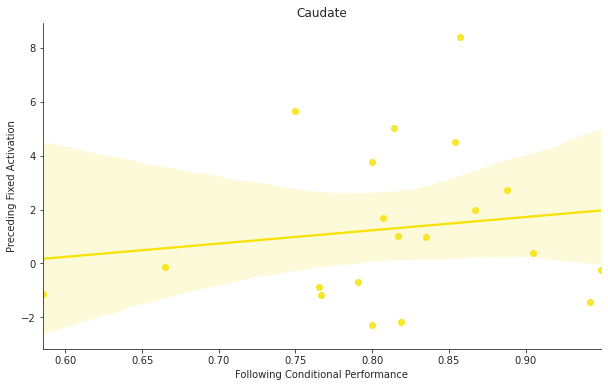

In [15]:
x = all_data_df['prop_corr']
y = all_data_df['caud_all_before_B']

print('FIXED --> COND', pearsonr(x,y))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'prop_corr', y = 'caud_all_before_B', color = "#f7e200", data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Caudate')
plt.show()

## Putamen

FIXED --> COND (0.12578587651910209, 0.5972098559772712)


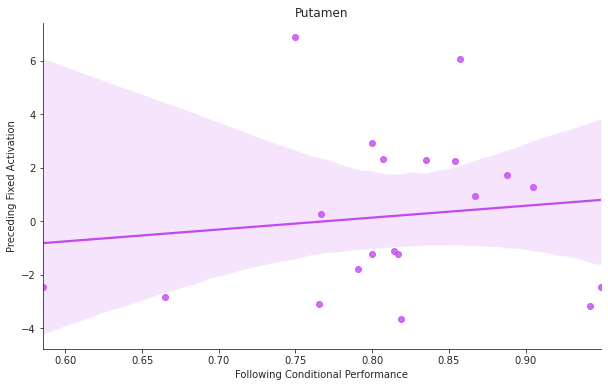

In [16]:
x = all_data_df['prop_corr']
y = all_data_df['put_all_before_B']

print('FIXED --> COND', pearsonr(x,y))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'prop_corr', y = 'put_all_before_B', color = "#c34aef", data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Putamen')
plt.show()